In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.autograd as autograd

import os
import numpy as np
import random
import re

In [2]:
#helper functions
def openFile(path):
    f = open(path, "r")
    return f.read() 

def imshow(img,text,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

In [57]:
class SiameseLSTM(nn.Module):
    hdim = 32
    def __init__(self, embedding_dim, vocab_size):
        super(SiameseLSTM, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hdim, num_layers=2)#, bidirectional=True)
        
        self.hidden = self.initHidden(self.hdim)
        self.output = nn.Linear(self.hdim, 1)

        
    def initHidden(self, dim):
        return (autograd.Variable(torch.zeros(2, 1, dim)),
        autograd.Variable(torch.zeros(2, 1, dim)))
        
    def forward_once(self, lyric):
        embeds = self.embeddings(lyric)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(lyric), 1, -1), self.hidden1)
        scores = self.output(lstm_out.view(len(lyric), -1))
        return scores

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
#         print(output1, output2)
        out1 = output1[len(output1)-1]
        out2 = output2[len(output2)-1]
#         return F.softmax(-torch.abs(out1-out2))
        return torch.abs(out1 - out2)

In [4]:
class LyricDataset(Dataset):
    def __init__(self, pathToData, numClasses, should_invert=True):
        self.pathToData = pathToData
        self.data = [path for path in os.listdir(self.pathToData) if os.path.isdir(self.pathToData + "/" + path)]
        self.should_invert = should_invert
        self.numClasses = numClasses
    
    def __getitem__(self, index):
        labels = self.data
        sameClass = random.randint(0,1)
        song1 = None
        song2 = None
        if sameClass: 
            label = random.randint(0, self.numClasses-1)
            classPath = self.pathToData + "/" + labels[label]
            songs = [path for path in os.listdir(classPath) if not path.startswith(".")]
            index1 = random.randint(0,len(songs)-1)
            s1Path = classPath + "/" + songs[index1]
            index2 = index1 
            while index2 == index1:
                index2 = random.randint(0,len(songs)-1)
            s2Path = classPath + "/" + songs[index2]
#             print(songs[index1], songs[index2])

        else:
            label1 = random.randint(0, self.numClasses-1)
            label2 = label1
            while label2 == label1:
                label2 = random.randint(0, self.numClasses-1)
            classPath1 = self.pathToData + "/" + labels[label1]
            songs1 = [path for path in os.listdir(classPath1) if not path.startswith(".")]
            index1 = random.randint(0,len(songs1)-1)
            s1Path = classPath1 + "/" + songs1[index1]
            classPath2 = self.pathToData + "/" + labels[label2]
            songs2 = [path for path in os.listdir(classPath2) if not path.startswith(".")]
            index2 = random.randint(0,len(songs2)-1)
            s2Path = classPath2 + "/" + songs2[index2]
#             print(songs1[index1], songs2[index2])
        s1 = openFile(s1Path)
        lyric1 = [convertForDict(word) for word in s1.split(" ")]
        s2 = openFile(s2Path)
        lyric2 = [convertForDict(word) for word in s2.split(" ")]
        return lyric1, lyric2, sameClass
    
    def __len__(self):
        return sum([len(os.listdir(self.pathToData + "/" + p)) for p in os.listdir(self.pathToData) if p != ".DS_Store"])


In [5]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        return torch.abs(torch.mean(torch.abs(output1-output2))- label)



In [6]:
PATH = "/Users/alexchan/Documents/college/susa/LyricNet/train"
dataset = LyricDataset(PATH, 2)
dataset

In [7]:
def convertForDict(word):
    pattern = re.compile('[\W_]+')
    word = pattern.sub('', word)
    return word.lower()

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)

word_to_ix = {}
labels = dataset.data
for artist in labels:
    for song in os.listdir(dataset.pathToData + "/" + artist):
        for word in openFile(dataset.pathToData + "/" + artist + "/" + song).split(" "):
            word = convertForDict(word)
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)


In [8]:
train_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=3)

In [9]:
counter = []
loss_history = []
avg_loss = []
iteration = 0 

In [58]:
EDIM = 64

model = SiameseLSTM(EDIM, len(word_to_ix))
loss = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(5):
    for i, data in enumerate(dataset):
        song1, song2, label = data
        song1, song2 = prepare_sequence(song1, word_to_ix), prepare_sequence(song2, word_to_ix)
        label = Variable(torch.FloatTensor([label]))
        model.hidden1 = model.initHidden(32)
        out = model(song1, song2)
        optimizer.zero_grad()
        total_loss = loss(out, label)
        total_loss.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,total_loss.data[0]))
            iteration += 10
            counter.append(iteration)
            loss_history.append(total_loss.data[0])
            avg_loss.append((sum(loss_history))/len(loss_history))
        if i == 750:
            break


Epoch number 0
 Current loss 0.0012364690192043781

Epoch number 0
 Current loss 0.9475947022438049

Epoch number 0
 Current loss 0.001246273168362677

Epoch number 0
 Current loss 0.0006219727220013738

Epoch number 0
 Current loss 0.9415549039840698

Epoch number 0
 Current loss 0.9671517610549927

Epoch number 0
 Current loss 0.9959476590156555



KeyboardInterrupt: 

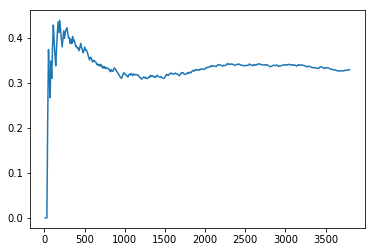

In [62]:
show_plot(counter,avg_loss)

In [40]:
for i, data in enumerate(dataset,0):
    song1, song2, label = data
    song1, song2 = prepare_sequence(song1, word_to_ix), prepare_sequence(song2, word_to_ix)
    label = Variable(torch.FloatTensor([label]))
    model.hidden1 = model.initHidden(32)
    out = model(song1, song2)
    print(label)
    print(out)
    if i == 0:
        break

shake_it_off.txt bad_blood.txt
Variable containing:
 1
[torch.FloatTensor of size 1]

Variable containing:
 0.9191
[torch.FloatTensor of size 1]

